In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
df = pd.read_csv('/content/pima_indian_data.csv')
df

,Number of times pregnant,Plasma glucose,Diastolic blood pressure,Triceps skinfold thickness,serum insulin,Body mass index,Diabetes pedigree function,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## This dataset has numerical variables and we have to predict if a person has diabetes or not.The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset.The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Number  of times pregnant   768 non-null    int64  
 1   Plasma glucose              768 non-null    int64  
 2   Diastolic blood pressure    768 non-null    int64  
 3   Triceps skinfold thickness  768 non-null    int64  
 4   serum insulin               768 non-null    int64  
 5   Body mass index             768 non-null    float64
 6   Diabetes pedigree function  768 non-null    float64
 7   Age                         768 non-null    int64  
 8   Class                       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
df.isna().sum()

Number  of times pregnant     0
Plasma glucose                0
Diastolic blood pressure      0
Triceps skinfold thickness    0
serum insulin                 0
Body mass index               0
Diabetes pedigree function    0
Age                           0
Class                         0
dtype: int64

# It looks like there are no missing values in this dataset.So, there is no need for cleaning the data

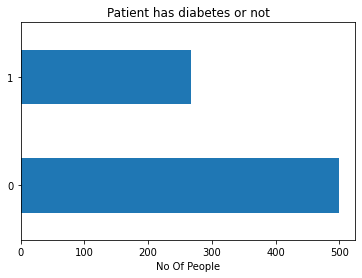

In [4]:
df['Class'].value_counts().plot.barh()
plt.title('Patient has diabetes or not')
plt.xlabel('No Of People')
plt.show()

# There are almost 500 people without diabetes and only around  268 have diabetes as seen from the above distribution

# **Getting ready for split**

In [5]:
y = df['Class']
X = df[[x for x in df.columns if x != 'Class']]

## Splitting the dataset

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# **Creating a base pipeline to choose the scoring metric**

### Using StandardScaler to standardize this numerical dataset.I prefered using Ridge regression(l2) for all the pipelines.

In [8]:
num_pipeline = Pipeline([('standardize_num', StandardScaler())])

In [9]:
num_vars = list(df.columns)[0:-1]
processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, num_vars)])
processing_pipeline

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('proc_numeric',
                                 Pipeline(memory=None,
                                          steps=[('standardize_num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True))],
                                          verbose=False),
                                 ['Number  of times pregnant', 'Plasma glucose',
                                  'Diastolic blood pressure',
                                  'Triceps skinfold thickness', 'serum insulin',
                                  'Body mass index',
                                  'Diabetes pedigree function', 'Age'])],
                  verbose=False)

In [10]:
modeling_pipeline = Pipeline([('data_processing', processing_pipeline),('logreg', LogisticRegression('l2'))])

In [11]:
m=modeling_pipeline.fit(X_train, y_train)

In [12]:
y_hat = m.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       100
           1       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154



In [13]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_hat))

[[84 16]
 [24 30]]


In [ ]:
accuracy_base_model=(confusion_matrix(y_test, y_hat)[0][0]+confusion_matrix(y_test, y_hat)[1][1])/np.sum(confusion_matrix(y_test, y_hat))
f1_base=confusion_matrix(y_test, y_hat)[0][0]/(confusion_matrix(y_test, y_hat)[0][0]+0.5*(confusion_matrix(y_test, y_hat)[0][1]+confusion_matrix(y_test, y_hat)[1][0]))
precision_base=confusion_matrix(y_test, y_hat)[0][0]/(confusion_matrix(y_test, y_hat)[0][0]+confusion_matrix(y_test, y_hat)[0][1])

In [15]:
# m.predict_proba(X)[:, 1]

In [16]:
from sklearn.metrics import roc_curve
fpr_test, tpr_test,a=roc_curve(y_test, m.predict_proba(X_test)[:, 1])
fpr_train, tpr_train,b=roc_curve(y_train, m.predict_proba(X_train)[:, 1])

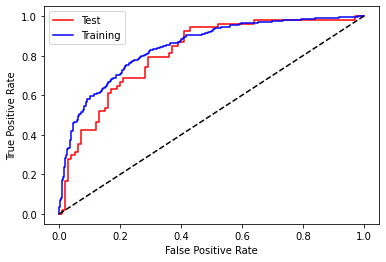

In [17]:
plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.show()

In [18]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,  m.predict_proba(X_test)[:, 1])

0.8144444444444444

# **Pick a metric you are going to use to select the model and justify your choice**
## As the ROC curve checks the trade off between FP and TP, I chose ROC area under the curve as the scoring metric checks true positive, false positive rate in the graph and adjusts accordingly.

# **Use the above combined pipeline to run a Logistic Regression model with grid search cross-validation using 10 folds. Search 5 different regularization strengths and 2 solvers. What is the best model? How does it perform on the test set?**

In [19]:
def solver_reg(a):
  b=Pipeline([('data_processing', processing_pipeline),('logreg', LogisticRegression(penalty='l2',solver=a))])
  return b

In [21]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

##**Using 'liblinear' as solver**

In [28]:
gcv_results = GridSearchCV(estimator=solver_reg('liblinear'), param_grid=params, scoring='roc_auc',cv=10,refit=True)
gcv_results=gcv_results.fit(X_train, y_train)

In [29]:
gcv_results.best_score_

0.8390909090909091

## **ROC has increased from 81 to 83.9**

In [30]:
gcv_results.best_params_

{'logreg__C': 0.1, 'logreg__class_weight': 'balanced'}

In [31]:
gcv_results.best_estimator_

Pipeline(memory=None,
         steps=[('data_processing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('proc_numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('standardize_num',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['Number  of times pregnant',
                                                   'Plasma glucose',
                   

# the above pipeline seems to be the best model for 'liblinear' at regularization strength of 0.1

In [32]:
print(classification_report(y_test, y_testp))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       100
           1       0.64      0.69      0.66        54

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.76       154



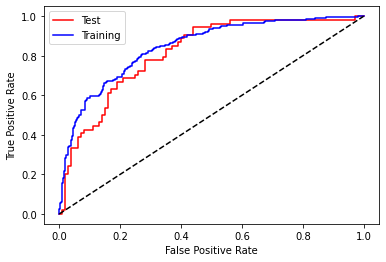

In [33]:
fpr_test, tpr_test,h=roc_curve(y_test, gcv_results.predict_proba(X_test)[:, 1])
fpr_train, tpr_train,l=roc_curve(y_train, gcv_results.predict_proba(X_train)[:, 1])
plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.show()

# Liblinear solver automatically selects the parameters taking its predecessor predicting output in our conidtion with the combination of AUC_Roc curve it checks the postive rate of the graph and then proceeds further using the Liblinear solver and got the maximum output.

# **Using the 'sag' solver**

In [20]:
from sklearn.model_selection import GridSearchCV
params = [{'logreg__class_weight': [None, 'balanced'],'logreg__C': [0.01,0.1,1,10,100]}]
gcv_results = GridSearchCV(estimator=solver_reg('sag'), param_grid=params, scoring='roc_auc',cv=10,refit=True)
gcv_results=gcv_results.fit(X_train, y_train)

In [22]:
gcv_results.best_score_

0.8388636363636361

# ROC has increased from 81 to 83.88

In [23]:
gcv_results.best_params_

{'logreg__C': 0.1, 'logreg__class_weight': 'balanced'}

In [24]:
gcv_results.best_estimator_

Pipeline(memory=None,
         steps=[('data_processing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('proc_numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('standardize_num',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['Number  of times pregnant',
                                                   'Plasma glucose',
                   

# the above model seems to be best model for 'sag' solver with l2 regularization at strength of 0.1

In [25]:
y_testp = gcv_results.predict(X_test)

In [26]:
print(classification_report(y_test, y_testp))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       100
           1       0.64      0.69      0.66        54

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.76       154



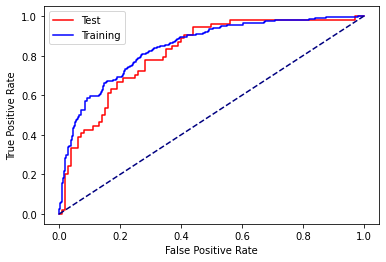

In [27]:
fpr_test, tpr_test,f=roc_curve(y_test, gcv_results.predict_proba(X_test)[:, 1])
fpr_train, tpr_train,g=roc_curve(y_train, gcv_results.predict_proba(X_train)[:, 1])
plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

# Stocastic Average gradient solver is mainly used on large dataset which takes the loss function to proceed for its further prediction. This being small dataset when performed sag with 'roc_auc' as metric has got improvement over the base pipeline,but not as good as the liblinear solver.